# IAU 2023/2024
## **Autori:** Laura Fulajtárová (50%), Bruno Kristián (50%)

# Fáza 2 - Predspracovanie údajov

In [113]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import iqr
import statsmodels.stats as sm_stats
from sklearn import preprocessing
import statsmodels.stats.api as sms
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [114]:
product = pd.read_csv("product_phase_1.csv", sep='\t')
user = pd.read_csv("user_phase_1.csv", sep='\t')
session = pd.read_csv("session_phase_1.csv", sep='\t')

### Datasets merge

In [115]:
set1 = set(session['product_ean'])
set2 = set(product['product_ean'])
common_values = set1.intersection(set2)

if common_values:
    print("Common values found in 'product_ean'.")
else:
    print("No common values found in 'product_ean'.")

No common values found in 'product_ean'.


Zistili sme, že datasety nevieme spojiť na základe stĺpca "product_ean", pretože sme nenašli žiadne spoločné hodnoty.  

In [116]:
set1 = set(session['user_id'])
set2 = set(user['old_user_id'])
common_values = set1.intersection(set2)

if common_values:
    print("Common values found in 'user_id'.")
else:
    print("No common values found in 'user_id'.")

Common values found in 'user_id'.


Vedeli by sme spojiť datasety na základe stĺpca "user_id" a "old_user_id". Tieto dva stĺpce sú v oboch datasetoch a majú spoločné hodnoty. 

In [117]:
user.rename(columns={'user_id': 'new_user_id', 'old_user_id': 'user_id'}, inplace=True)

In [118]:
merged_data = pd.merge(user, session, on='user_id', how='inner')

Spojili sme datasety na základe stĺpa "user_id". Použili sme funkciu merge z knižnice pandas s parametrom how = "inner". 

Vznikol nám nový dataset, ktorý obsahuje všetky stĺpce z oboch datasetov.

### Premena atribútov na numerické hodnoty

In [119]:
merged_data.dtypes

birthdate                          object
sex                                object
registration                       object
new_user_id                         int64
race                               object
user_id                             int64
pct_mouse_click                   float64
pct_scroll_move                   float64
pct_doubleclick                   float64
pct_input                         float64
session_start                      object
page_activity_duration            float64
ack                               float64
pct_click                         float64
pct_mouse_move                    float64
browser_name                       object
pct_scrandom                      float64
pct_scroll_move_duration          float64
mouse_move_total_rel_distance     float64
product_ean                         int64
pct_rage_click                    float64
pct_wild_mouse                    float64
session_duration                  float64
wild_mouse_duration               

dátumy v stĺpeci "birthdate" najskôr premeníme na čísla

In [120]:
merged_data['birthdate'] = pd.to_datetime(merged_data['birthdate'], errors='coerce')
merged_data['numeric_birthdate'] = merged_data['birthdate'].dt.strftime('%Y%m%d').astype(float)

merged_data.drop('birthdate', axis=1, inplace=True)
merged_data.rename(columns={'numeric_birthdate': 'birthdate'}, inplace=True)

premeníme stĺpec "sex" " na čísla 

    male = 1
    female = 0

In [121]:
merged_data['sex'].unique()

array(['F', nan, 'M'], dtype=object)

In [122]:
sex_mapping = {'F': 0, 'M': 1}
merged_data['sex_numeric'] = merged_data['sex'].replace(sex_mapping)

merged_data.drop('sex', axis=1, inplace=True)
merged_data.rename(columns={'sex_numeric': 'sex'}, inplace=True)


premeníme stĺpec "registration" na čísla

In [123]:
merged_data['registration'] = pd.to_datetime(merged_data['registration'], errors='coerce')
merged_data['numeric_registration'] = merged_data['registration'].dt.strftime('%Y%m%d').astype(float)

merged_data.drop('registration', axis=1, inplace=True)
merged_data.rename(columns={'numeric_registration': 'registration'}, inplace=True)

premeníme stĺpec "session_start" na čísla

In [124]:
merged_data['session_start'].head()

0    2019-10-10 18:14:44
1    2019-10-10 18:14:44
2    2019-05-27 00:51:40
3    2023-05-27 22:53:57
4    2019-05-27 00:51:40
Name: session_start, dtype: object

In [125]:
merged_data['session_start'] = pd.to_datetime(merged_data['session_start'])
merged_data['timestamp'] = (merged_data['session_start'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(seconds=1)
merged_data['numeric_session_start'] = merged_data['timestamp'].astype(int)

merged_data.drop('session_start', axis=1, inplace=True)
merged_data.rename(columns={'numeric_session_start': 'session_start'}, inplace=True)

premeníme stĺpec "browser_name" na čísla

In [126]:
merged_data["browser_name"].unique()

array(['opera', 'safari', 'firefox', 'chrome', 'edge', 'mobile', 'other'],
      dtype=object)

    opera = 1
    safari = 2
    firefox = 3
    chrome = 4
    edge = 5
    mobile = 6
    other = 7

In [127]:
browser_mapping = {'opera' : 1, 
                   'safari' : 2, 
                   'firefox' : 3, 
                   'chrome' : 4, 
                   'edge' : 5, 
                   'mobile' : 6, 
                   'other' : 7}
merged_data['browser_name_numeric'] = merged_data['browser_name'].replace(browser_mapping)
merged_data.drop('browser_name', axis=1, inplace=True)
merged_data.rename(columns={'browser_name_numeric': 'browser_name'}, inplace=True)

premeníme stĺpec "race" na číselné hodnoty

In [128]:
merged_data["race"].unique()

array([nan, 'unspecified', 'black', 'asian', 'white', 'indian'],
      dtype=object)

In [129]:
merged_data['race'] = merged_data['race'].replace('unspecified', np.nan)

    white = 1
    black = 2
    asian = 3
    indian = 4

In [130]:
race_mapping = {'white' : 1, 
                'black' : 2, 
                'asian' : 3, 
                'indian' : 4
}
merged_data['race_numeric'] = merged_data['race'].replace(race_mapping)
merged_data.drop('race', axis=1, inplace=True)
merged_data.rename(columns={'race_numeric': 'race'}, inplace=True)

In [131]:
column_order = ['birthdate', 
                'sex', 
                'registration',
                'new_user_id',
                'race',
                'user_id',
                'pct_mouse_click',
                'pct_scroll_move',
                'pct_doubleclick',
                'pct_input',
                'session_start',
                'page_activity_duration',
                'ack',
                'pct_click',
                'pct_mouse_move',
                'browser_name',
                'pct_scrandom',
                'pct_scroll_move_duration',
                'mouse_move_total_rel_distance',
                'product_ean',
                'pct_rage_click',
                'pct_wild_mouse',
                'session_duration',
                'wild_mouse_duration',
                'session_id',
                'pct_click_product_info',
                'scroll_move_total_rel_distance',
                'total_load_time',
                'screen_width',
                'screen_height',
                ]
merged_data = merged_data[column_order]



In [132]:
merged_data.dtypes

birthdate                         float64
sex                               float64
registration                      float64
new_user_id                         int64
race                              float64
user_id                             int64
pct_mouse_click                   float64
pct_scroll_move                   float64
pct_doubleclick                   float64
pct_input                         float64
session_start                       int32
page_activity_duration            float64
ack                               float64
pct_click                         float64
pct_mouse_move                    float64
browser_name                        int64
pct_scrandom                      float64
pct_scroll_move_duration          float64
mouse_move_total_rel_distance     float64
product_ean                         int64
pct_rage_click                    float64
pct_wild_mouse                    float64
session_duration                  float64
wild_mouse_duration               

### Nahradenie chýbajúcich hodnôt

In [133]:
merged_data.isnull().sum()

birthdate                         4929
sex                               5497
registration                         0
new_user_id                          0
race                              8540
user_id                              0
pct_mouse_click                     19
pct_scroll_move                     13
pct_doubleclick                     10
pct_input                            8
session_start                        0
page_activity_duration              14
ack                                  0
pct_click                           17
pct_mouse_move                      10
browser_name                         0
pct_scrandom                         6
pct_scroll_move_duration            10
mouse_move_total_rel_distance       16
product_ean                          0
pct_rage_click                      16
pct_wild_mouse                      20
session_duration                     0
wild_mouse_duration                 14
session_id                           0
pct_click_product_info   

In [134]:
def custom_imputer(column_with_nulls, desired_distribution):
    # Calculate the number of null values to fill
    total_count = len(column_with_nulls)
    num_nulls_to_fill = column_with_nulls.isnull().sum()

    # Calculate the number of occurrences for each race value
    counts = {value: int((percentage / 100) * total_count) for value, percentage in desired_distribution.items()}

    # Generate a list of race values to fill nulls
    list_of_values = []
    for value, count in counts.items():
        list_of_values.extend([value] * count)

    # Randomly shuffle the list to maintain the distribution
    np.random.shuffle(list_of_values)

    # Fill null values with the shuffled race values
    column_with_nulls[column_with_nulls.isnull()] = list_of_values[:num_nulls_to_fill]

Vieme, že pohlavie je v tatasete rovnomerne distribuované, preto ho môžeme nahradiť random hodnotami 0 a 1.

In [135]:
import random

merged_data_imputed = merged_data.copy()

sex_percentages_dict = {1.0: 48.9,
                        0.0: 51.1
}

custom_imputer(merged_data_imputed['sex'], sex_percentages_dict)

c:\Users\default.LAPTOP-E7URUV4I\Desktop\IAU\IAU-course\iau\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


To isté prevedieme aj s rasou

In [136]:
race_percentages_dict = (merged_data['race'].value_counts(normalize=True) * 100).to_dict()
custom_imputer(merged_data_imputed['race'], race_percentages_dict)

c:\Users\default.LAPTOP-E7URUV4I\Desktop\IAU\IAU-course\iau\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Pomocou kNN algoritmu doplníme hodnoty v stĺpci "pct_mouse_click"

In [137]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

merged_data_imputed['pct_mouse_click'] = knn_imputer.fit_transform(merged_data_imputed[['pct_mouse_click']])


všetky chýbajúce hodnoty okrem dátumu narodenia nahradíme priemerom

In [138]:
from sklearn.impute import SimpleImputer

# Define a list of numeric column names
numeric_columns = [
    'pct_scroll_move', 
    'pct_doubleclick', 
    'pct_input', 
    'page_activity_duration', 
    'pct_click',  # Add a comma here
    'pct_mouse_move',  # Add a comma here
    'pct_scrandom', 
    'pct_scroll_move_duration', 
    'mouse_move_total_rel_distance',  # Add a comma here
    'pct_rage_click',  # Remove the space after column name
    'pct_wild_mouse', 
    'wild_mouse_duration', 
    'pct_click_product_info', 
    'scroll_move_total_rel_distance'
]

# Create a SimpleImputer instance and impute missing values with the mean for numeric columns
imputer = SimpleImputer(strategy='mean')
merged_data_imputed[numeric_columns] = imputer.fit_transform(merged_data_imputed[numeric_columns])


riadky s prázdnymi hodnotami odstránime

In [139]:
merged_data_imputed.dropna(inplace=True)

overíme, či sa nám datasety po nahradení hodnôt výrazne nezmenili   

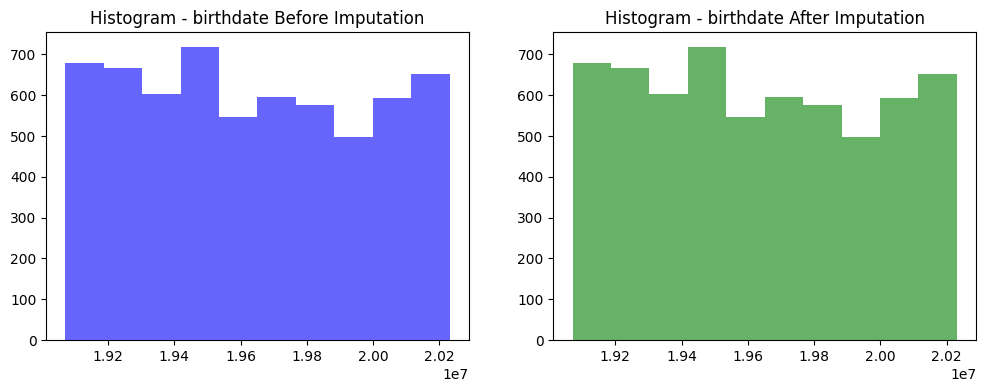

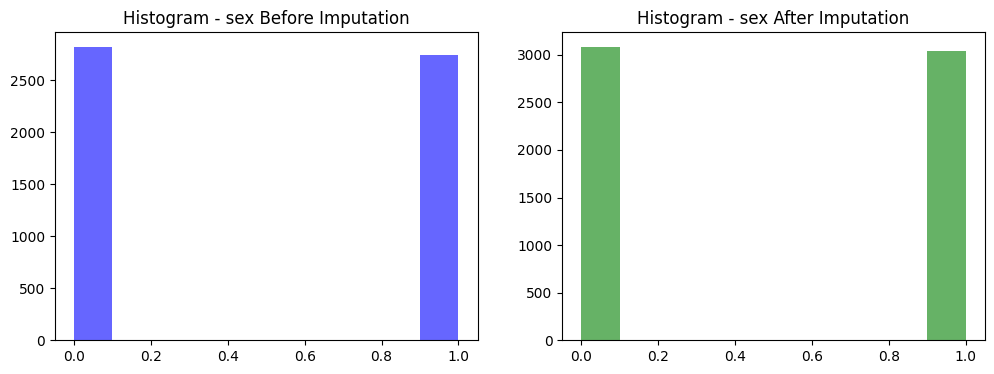

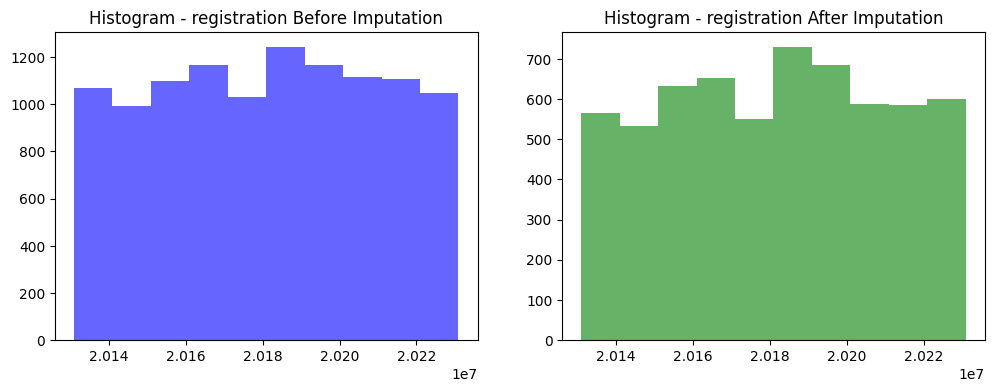

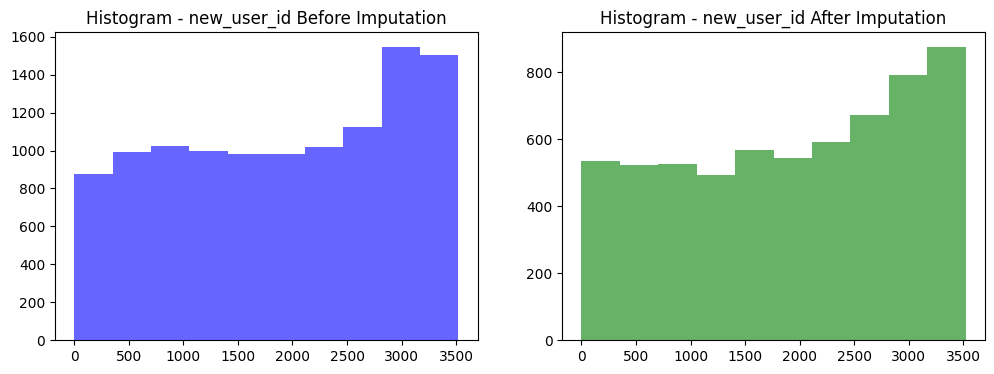

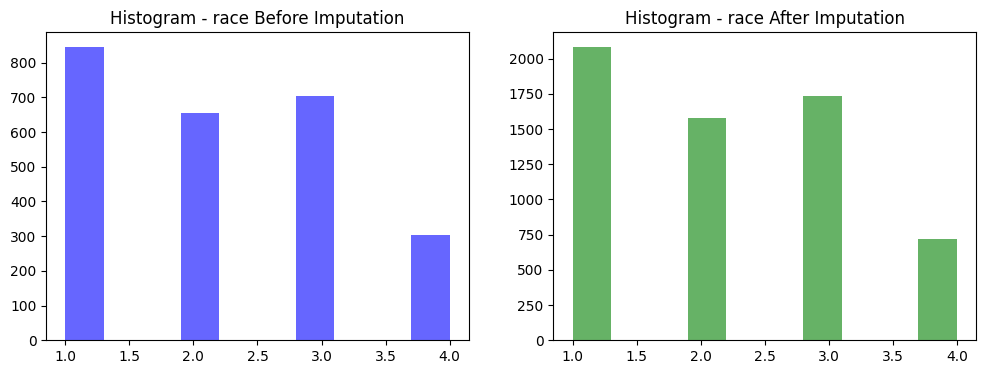

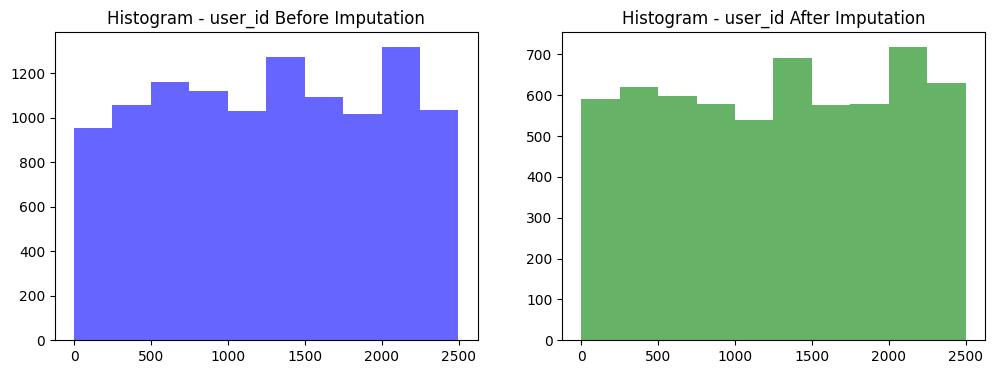

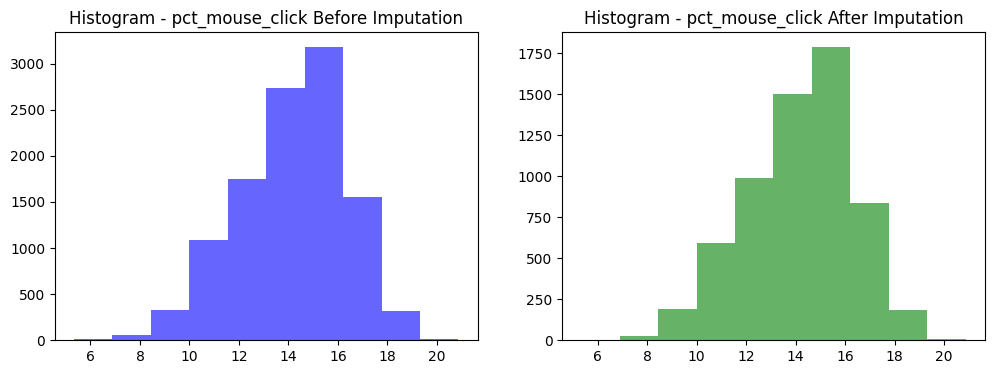

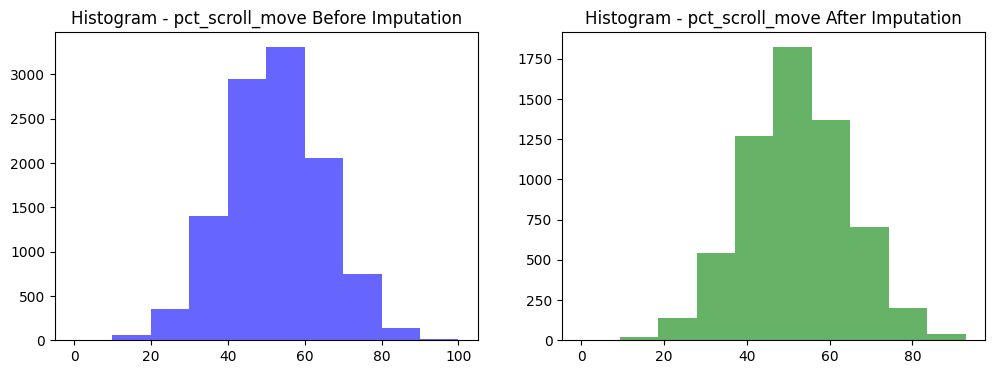

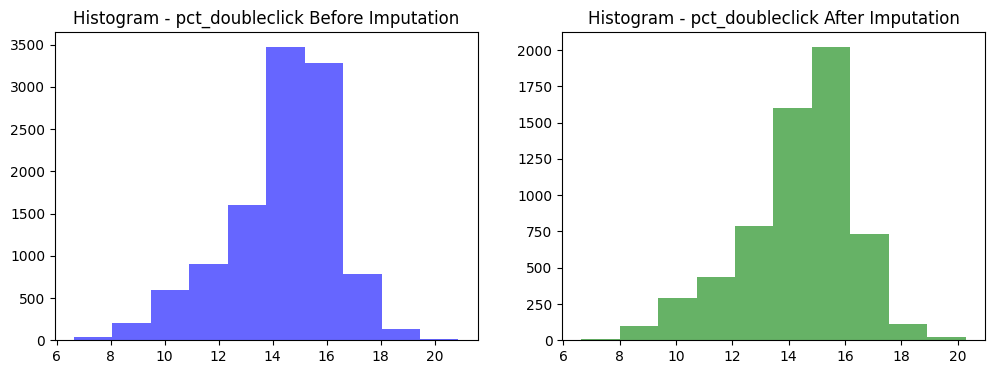

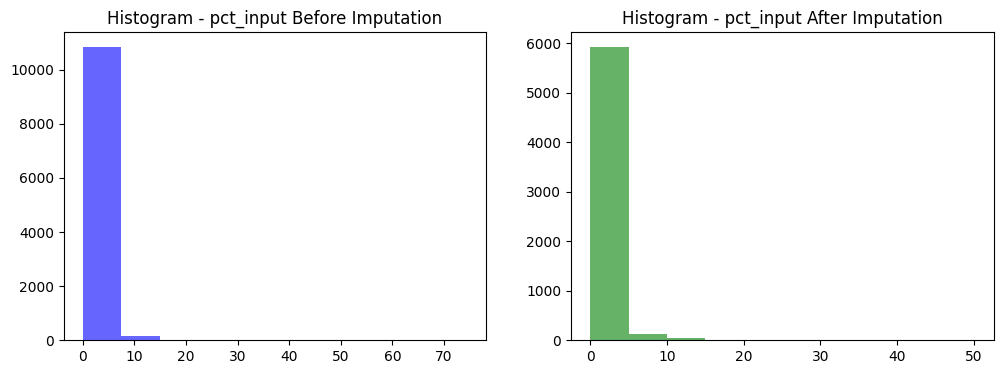

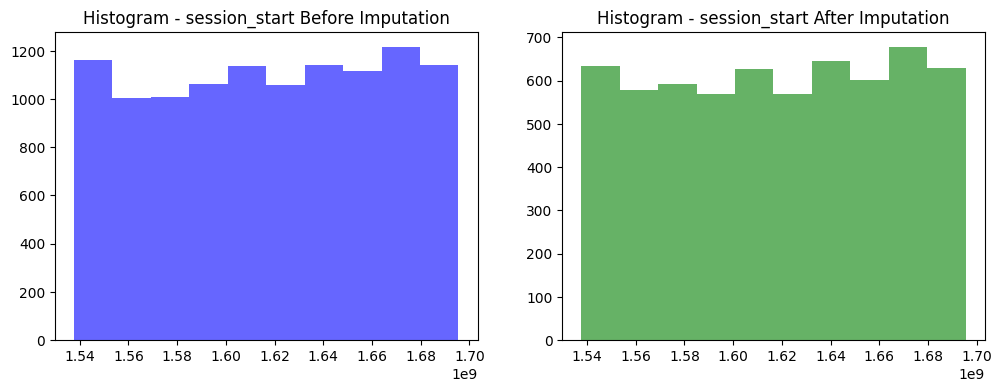

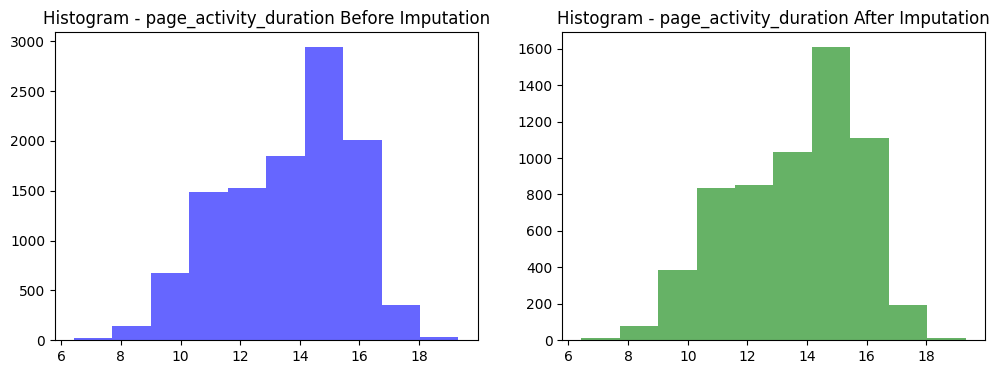

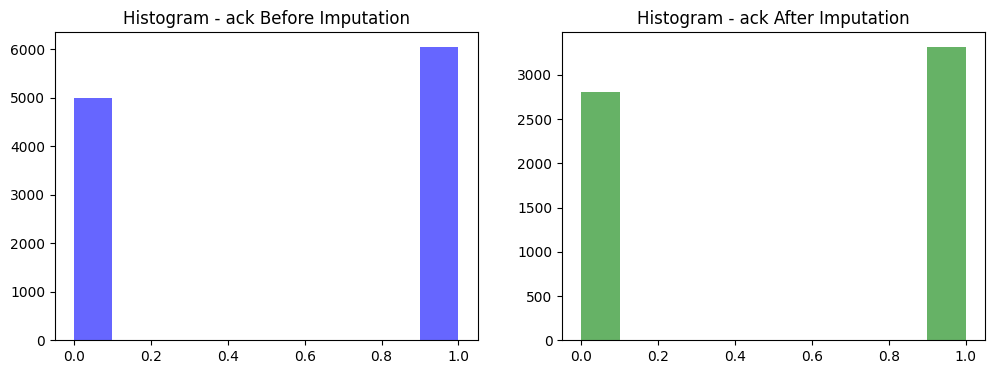

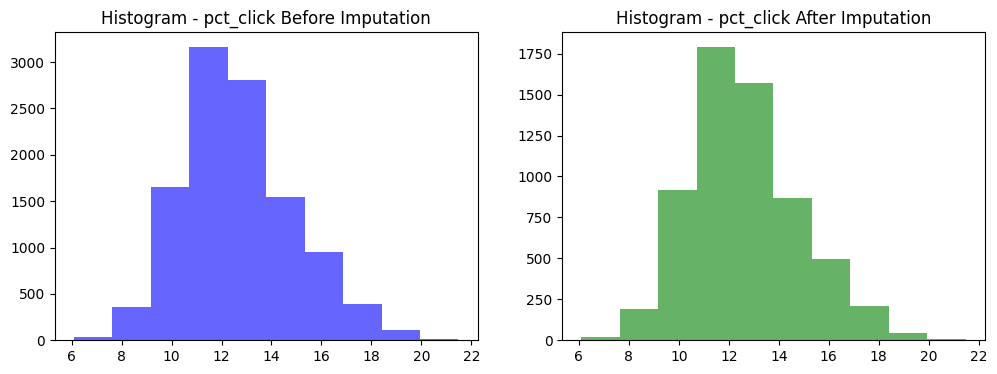

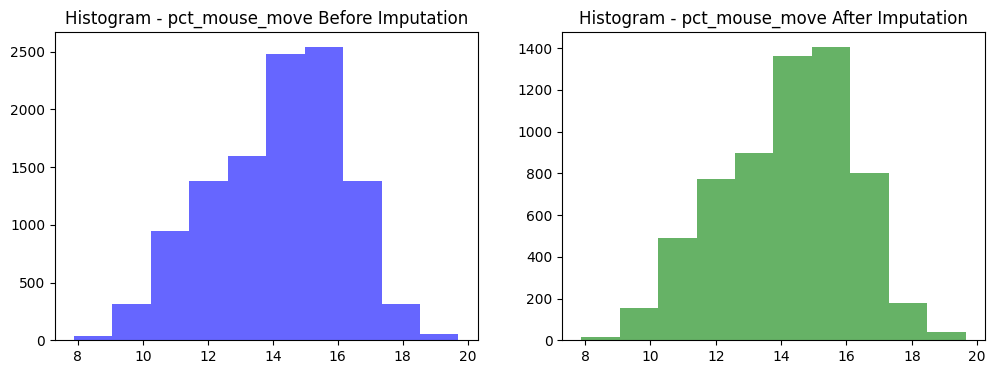

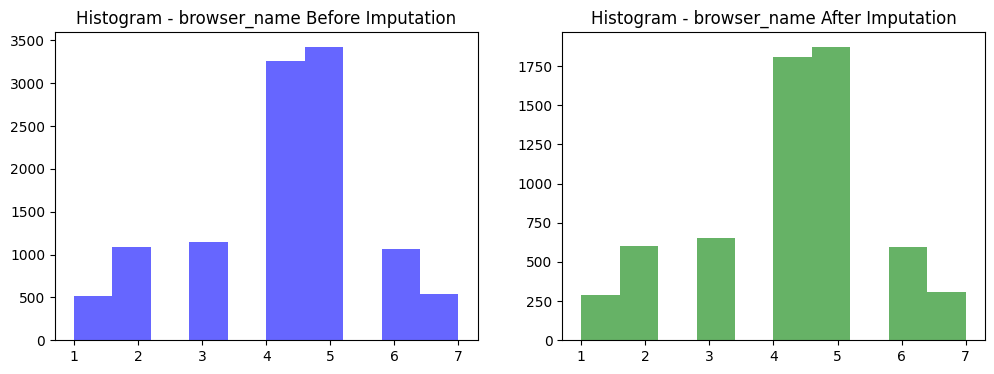

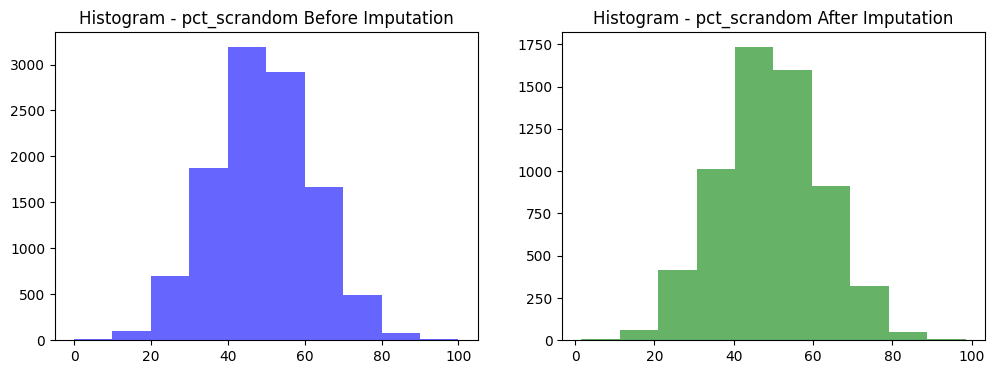

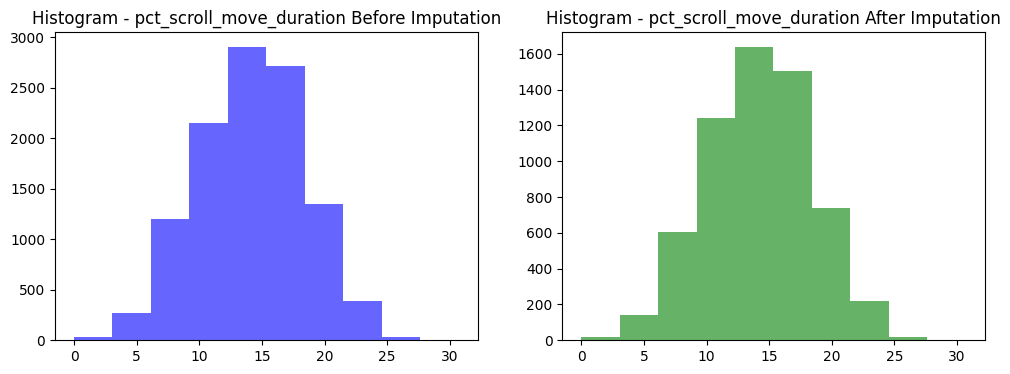

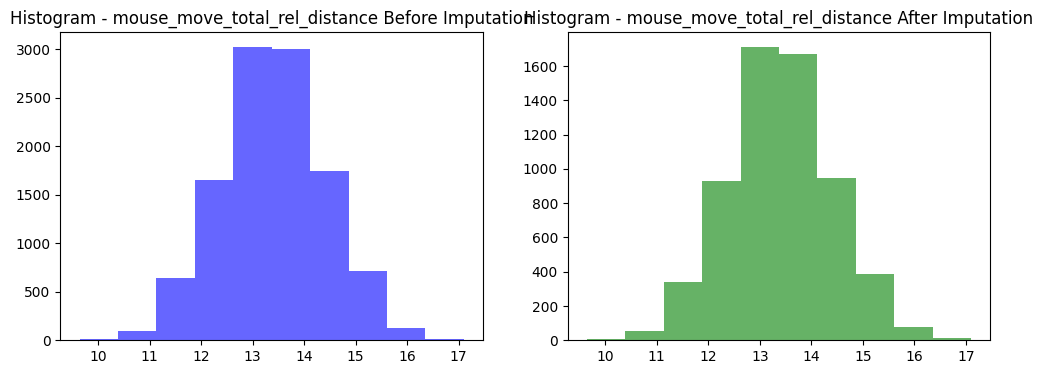

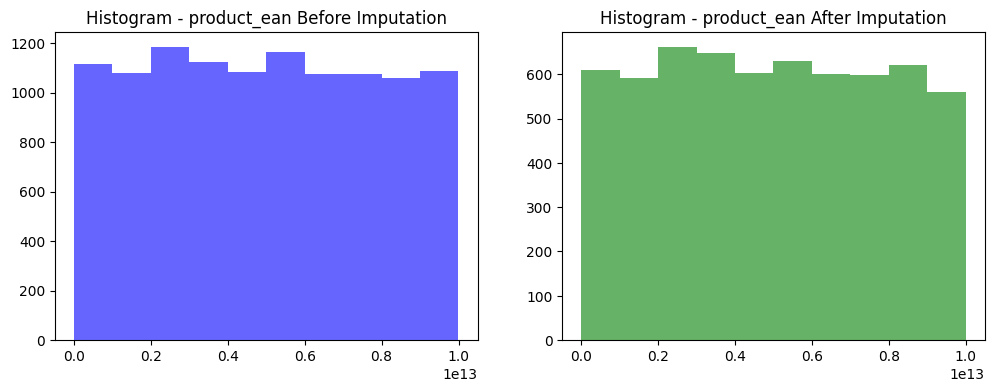

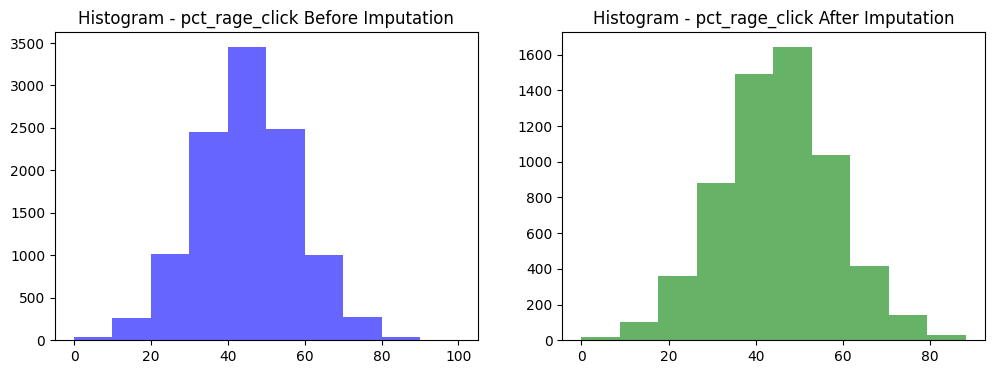

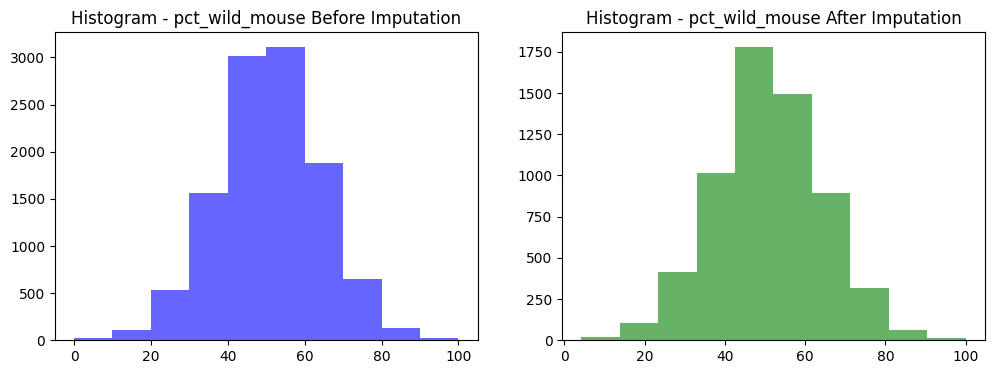

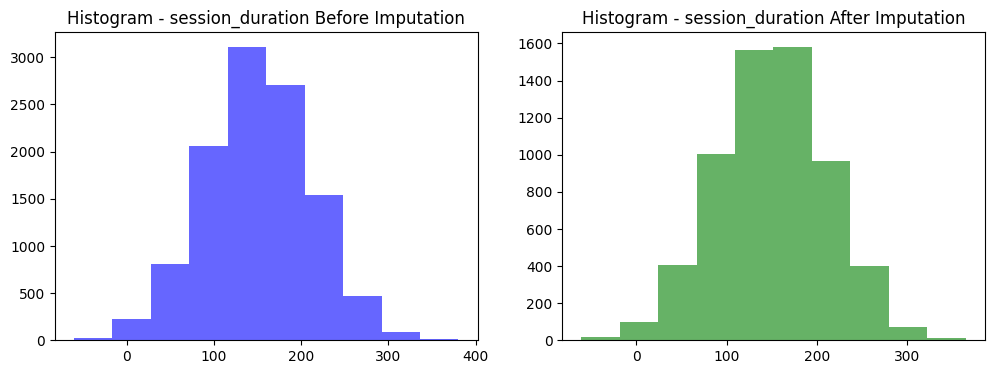

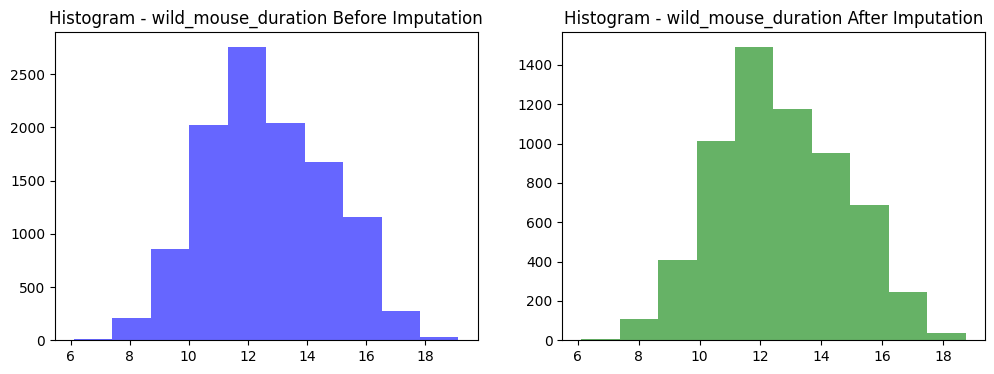

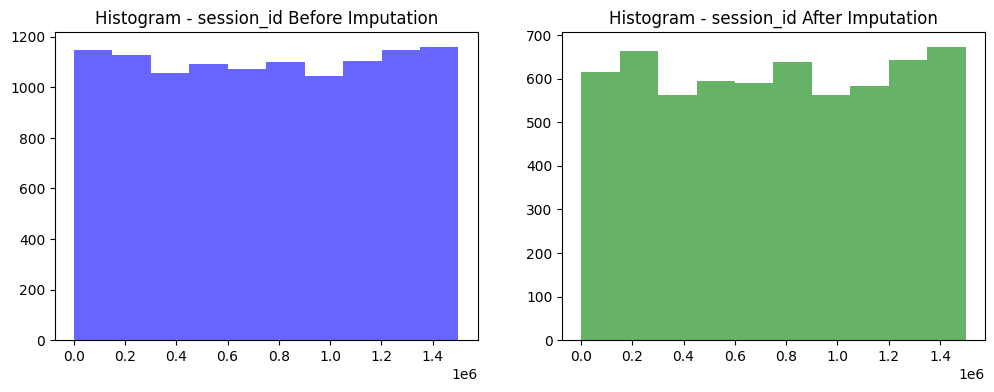

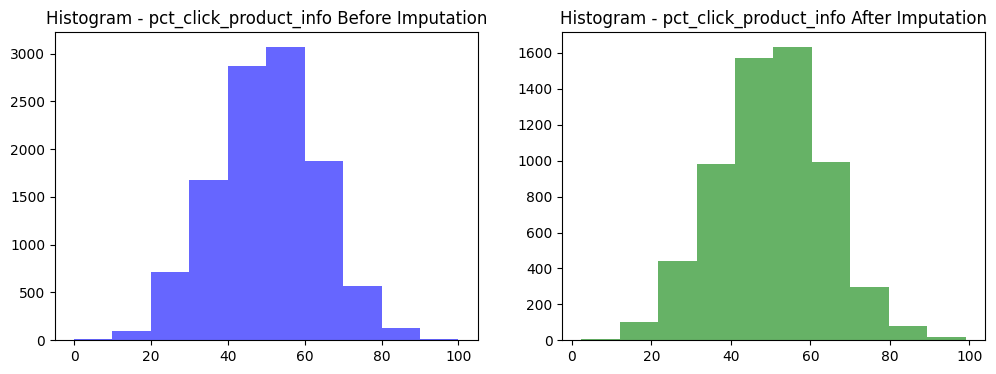

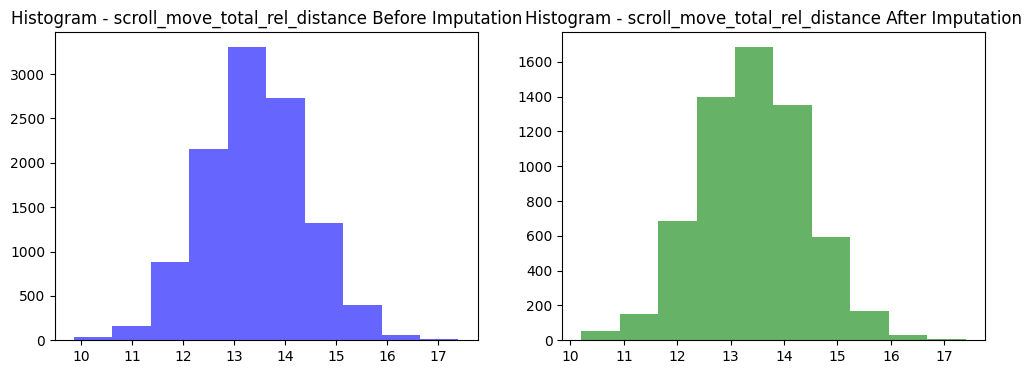

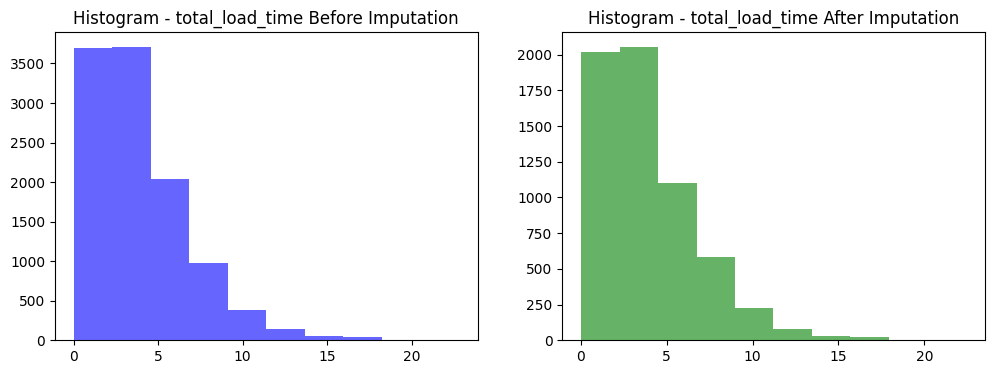

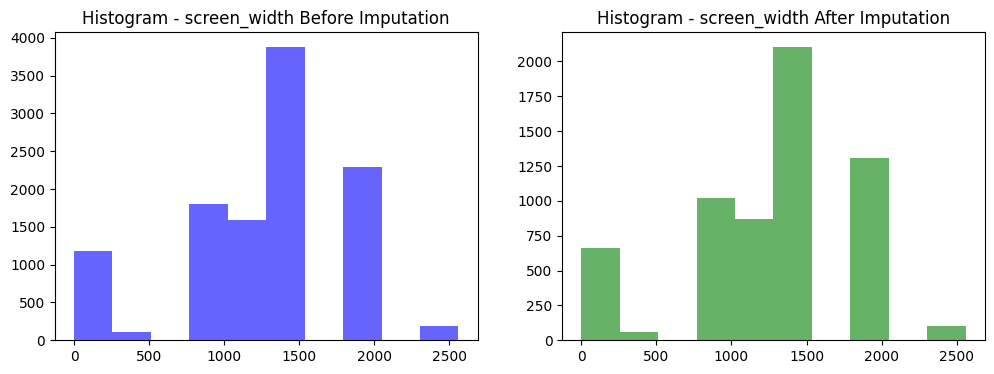

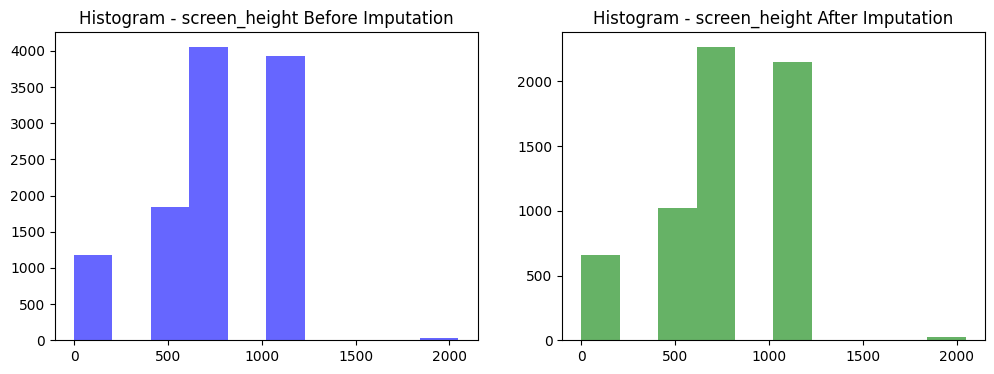

                            Column Similarity
0                        birthdate    Similar
1                              sex    Similar
2                     registration    Similar
3                      new_user_id    Similar
4                             race    Similar
5                          user_id    Similar
6                  pct_mouse_click    Similar
7                  pct_scroll_move    Similar
8                  pct_doubleclick    Similar
9                        pct_input    Similar
10                   session_start    Similar
11          page_activity_duration    Similar
12                             ack    Similar
13                       pct_click    Similar
14                  pct_mouse_move    Similar
15                    browser_name    Similar
16                    pct_scrandom    Similar
17        pct_scroll_move_duration    Similar
18   mouse_move_total_rel_distance    Similar
19                     product_ean    Similar
20                  pct_rage_click

In [140]:
from scipy.stats import ks_2samp

result_table = pd.DataFrame(columns=['Column', 'Similarity'])

for column in merged_data_imputed.columns:    
    # Visual comparison - histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(merged_data[column].dropna(), bins=10, alpha=0.6, color='b', label='Original')
    plt.title(f'Histogram - {column} Before Imputation')
    
    plt.subplot(1, 2, 2)
    plt.hist(merged_data_imputed[column], bins=10, alpha=0.6, color='g', label='Imputed')
    plt.title(f'Histogram - {column} After Imputation')
    
    plt.show()
    

    # Statistical test - Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(merged_data[column].dropna(), merged_data_imputed[column])
    alpha = 0.05
    if p_value < alpha:
        similarity = "Not Similar"
    else:
        similarity = "Similar"
    
    result_table = result_table.append({'Column': column, 'Similarity': similarity}, ignore_index=True)

print(result_table)


#### Vyplnili sme chybajúce údaje, tak aby sa ich distribúcia podobala distribúcii pôvodných dát

### Odstránenie vyhchýlených hodnôt

In [141]:
null_counts = merged_data_imputed.isnull().sum()
print(null_counts)

birthdate                         0
sex                               0
registration                      0
new_user_id                       0
race                              0
user_id                           0
pct_mouse_click                   0
pct_scroll_move                   0
pct_doubleclick                   0
pct_input                         0
session_start                     0
page_activity_duration            0
ack                               0
pct_click                         0
pct_mouse_move                    0
browser_name                      0
pct_scrandom                      0
pct_scroll_move_duration          0
mouse_move_total_rel_distance     0
product_ean                       0
pct_rage_click                    0
pct_wild_mouse                    0
session_duration                  0
wild_mouse_duration               0
session_id                        0
pct_click_product_info            0
scroll_move_total_rel_distance    0
total_load_time             

Vo všetkých stĺpcoch máme každé pole vyplnené

pozrieme sa, ktoré atribúty sú distribuované normálne a ktoré nie

In [144]:
normality_results = {}

# Iterate through each column
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        # Perform the Kolmogorov-Smirnov test
        stat, p = stats.kstest(df[column], 'norm')
        alpha = 0.05  # Significance level
        
        # Store the results in the dictionary
        normality_results[column] = {
            'statistic': stat,
            'p-value': p,
            'normality': 'Normal' if p > alpha else 'Not Normal'
        }

# Convert the results dictionary to a DataFrame for easier analysis and visualization
normality_results_df = pd.DataFrame(normality_results).T
print(normality_results_df)

                               statistic   p-value   normality
birthdate                            NaN       1.0      Normal
sex                                  NaN       1.0      Normal
registration                    0.953148       0.0  Not Normal
new_user_id                     0.940023       0.0  Not Normal
race                                 NaN       1.0      Normal
user_id                          0.95607       0.0  Not Normal
pct_mouse_click                      NaN       1.0      Normal
pct_scroll_move                      NaN       1.0      Normal
pct_doubleclick                      NaN       1.0      Normal
pct_input                            NaN       1.0      Normal
page_activity_duration               NaN       1.0      Normal
ack                             0.633353       0.0  Not Normal
pct_click                            NaN       1.0      Normal
pct_mouse_move                       NaN       1.0      Normal
browser_name                    0.932262       0.0  Not

c:\Users\default.LAPTOP-E7URUV4I\Desktop\IAU\IAU-course\iau\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Na dátach, ktoré majú norálne rozloženie (Gaussian distribution) použijeme Standard Deviation Method na odhalenie oulierov